In [1]:
import sys
sys.path.append('..')
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import datetime
import theano_lstm
import numpy as np
import data_managers
import os

# Plotting
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


In [2]:
reload(data_managers)
data_butler = data_managers.character_data_manager('/home/arimorcos/Github/CS281-Final-Project/data manager/',
                                                   minmax_doc_length=[0,300])

In [ ]:
# Create network 
config.mode="FAST_RUN"
hidden_size = 128
network = theano_lstm.lstm_rnn(300,
                  [(hidden_size, hidden_size),
                   (hidden_size, hidden_size)],
                  150, dropout=0.2)
# network.initialize_training_adadelta()
network.initialize_training_adam()

In [3]:
%%time
# Create network 
config.mode="FAST_RUN"
hidden_size = 128
network = theano_lstm.lstm_rnn(300,
                  [(hidden_size, hidden_size)],
                  150, dropout=0.2)
# network.initialize_training_adadelta()
network.initialize_training_adam(alpha=5e-5, beta1=0.95)

CPU times: user 54 s, sys: 756 ms, total: 54.8 s
Wall time: 54.7 s


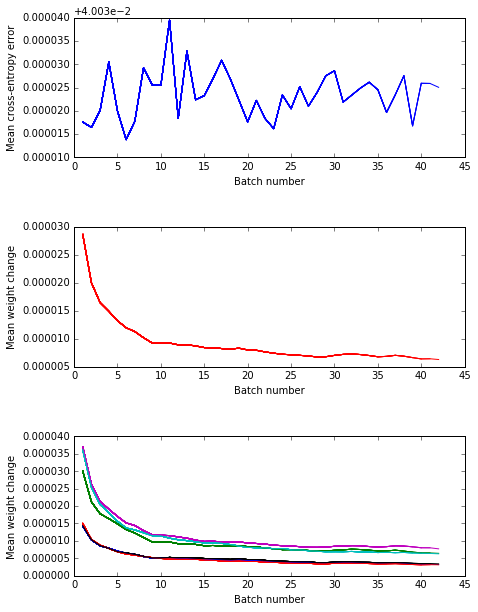

KeyboardInterrupt: 

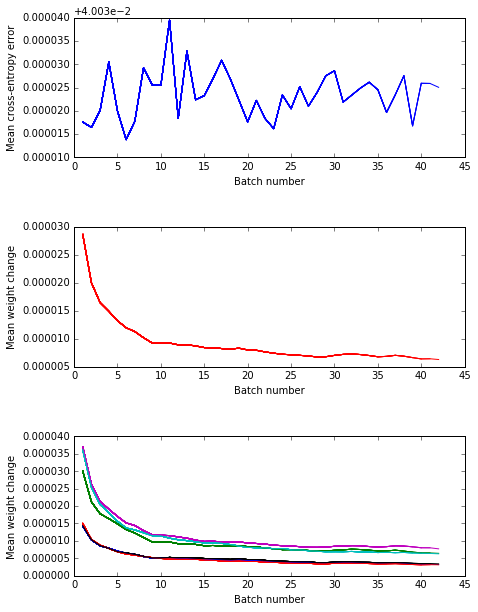

In [4]:
batch_size = 600
perms_per = 4
num_batches = 1000000
should_reinitialize = True
repeat_batch = 1
abbrev = 10

data_butler.set_batch_size(batch_size)
data_butler.set_perms_per(perms_per)
data_butler.set_stride(batch_size)

# Re-initialize network 
if should_reinitialize:
    network.initialize_network_weights()
    root_dir = '/media/1_TB_Internal/lstm_rnn_data'
    new_log_dir = os.path.join(root_dir, datetime.datetime.now().strftime('%y%m%d_%H%M%S'))
    network.set_log_dir(new_log_dir)

#Create plot 
fig = plt.figure(figsize=(7, 10))
fig.subplots_adjust(hspace=0.5)
ax_cost = fig.add_subplot(311)
ax_cost.set_xlabel('Batch number')
ax_cost.set_ylabel('Mean cross-entropy error')
ax_cost.get_yaxis().get_major_formatter().set_scientific(False)

ax_weight_change = fig.add_subplot(312)
ax_weight_change.set_xlabel('Batch number')
ax_weight_change.set_ylabel('Mean weight change')

ax_weight_change_ind = fig.add_subplot(313)
ax_weight_change_ind.set_xlabel('Batch number')
ax_weight_change_ind.set_ylabel('Mean weight change')
ax_weight_change_ind.hold(True)

# Initialize cost 
cost = []
mean_diff_mag = []
mean_diff_mag_i = []
mean_diff_mag_f = []
mean_diff_mag_c = []
mean_diff_mag_o = []
mean_diff_mag_y = []
mean_diff_mag_r = []

# Offer data
# vectors, lengths, answers = data_butler.offer_data()
# vectors = vectors[:abbrev, :, :]
# lengths = [min(abbrev, vec_len) for vec_len in lengths]

for batch in range(num_batches):
    
    # Get data
#     vectors, lengths, answers = data_butler.permute_examples()
#     vectors = vectors[:abbrev, :, :]
#     lengths = [min(abbrev, vec_len) for vec_len in lengths]
    vectors, lengths, answers = data_butler.offer_data()
    
    # Step 
#     temp_cost, param_diff = network.adadelta_step(vectors, lengths, answers)
    for repeat in range(repeat_batch):
        temp_cost, param_diff = network.adam_step(vectors, lengths, answers)
        cost.append(temp_cost.tolist())
    
        # Calculate mean param_diff magnitude
        temp_mean_diff_mag = [np.abs(diff).mean() for diff in param_diff]
        mean_diff_mag.append(np.mean(temp_mean_diff_mag))
        
        # append indi
        mean_diff_mag_i.append(temp_mean_diff_mag[0])
        mean_diff_mag_f.append(temp_mean_diff_mag[2])
        mean_diff_mag_c.append(temp_mean_diff_mag[4])
        mean_diff_mag_o.append(temp_mean_diff_mag[6])
        mean_diff_mag_y.append(temp_mean_diff_mag[8])
        mean_diff_mag_r.append(temp_mean_diff_mag[10])

        # Update plot 
        try:
            upper_lim = len(cost) + 1
        except:
            upper_lim = 2
        x_vals = range(1, upper_lim)
        ax_cost.plot(x_vals, cost, 'b')
        ax_weight_change.plot(x_vals, mean_diff_mag, 'r')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_i, 'b')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_f, 'r')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_c, 'g')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_o, 'k')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_y, 'm')
        ax_weight_change_ind.plot(x_vals, mean_diff_mag_r, 'c')
        display.clear_output(wait=True)
        display.display(fig)
    
    data_butler.advance_schedule()

In [ ]:
d = data_butler.get_current_doc()

In [ ]:
q = data_butler.get_current_queries()

In [ ]:
q[0]['a']

In [ ]:
d[0]['text']